In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
import platform
import pathlib  
import os.path
import netCDF4 as nc
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.errors import RasterioIOError
from shapely.geometry import Point
import time
from scipy.spatial import cKDTree

In [2]:
cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
OS_type = platform.system()

if OS_type == 'Darwin':
    username = 'Mats '
    data_path = os.path.join(data, 'data_tana', 'catchments')
    shape_path = os.path.join(data, 'data_tana', 'catchments')
    
else:
    username = 'Mootje'
    data_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Satellite')
    shape_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Shapefiles','Mini_shapes')

print(f"Welcome {username}, have a wondeful day on your {OS_type} machine. Your data should be located in {data_path}")
print(data_path)

Welcome Mootje, have a wondeful day on your Windows machine. Your data should be located in C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Satellite
C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Satellite


In [3]:
# print(data_path)

# path_subcatchments = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data','Shapefiles', 'Mini_shapes')
# path_satellite = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Satellite')
# path_save_new_shapefiles = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'subcatchments_chirps')

# shapefiles_fnames = os.path.join(path_subcatchments, '*.gpkg')
# shape_files = glob.glob(shapefiles_fnames)
# path_satellite = path_satellite.replace('\\', '\\\\')

# print(path_satellite)

# N = len(shapefiles_fnames)

In [4]:
data_files = glob.glob(os.path.join(data_path, '*.nc'))
print(data_files)
datasets = {}

for file_path in data_files:
    # Extract the file identifier from the file name
    file_name = os.path.basename(file_path)  # Get just the file name
    file_identifier = file_name.split('_')[0]  # Split by underscore and take the first part
    # print(file_identifier)
    # Open the dataset
    dataset = xr.open_dataset(file_path)
    # print(dataset)
    # Add the file identifier as a new coordinate
    dataset = dataset.assign_coords(file_identifier=file_identifier)
    
    # Add the dataset to the dictionary with the file identifier as the key
    datasets[file_identifier] = dataset
    # print(datasets[file_identifier])
chirps_file = data_files[0]

['C:\\Users\\Moniek van Zon\\OneDrive - Delft University of Technology\\TU Delft\\Master ENVM\\MDP\\Model\\Data\\Satellite\\chirps_2018_2022_28.45_43.55_-5.05_5.45.nc', 'C:\\Users\\Moniek van Zon\\OneDrive - Delft University of Technology\\TU Delft\\Master ENVM\\MDP\\Model\\Data\\Satellite\\era5_2018_2022_28.45_43.55_-5.05_5.45.nc', 'C:\\Users\\Moniek van Zon\\OneDrive - Delft University of Technology\\TU Delft\\Master ENVM\\MDP\\Model\\Data\\Satellite\\gsmap_gauge_v7_aoi_daily.nc', 'C:\\Users\\Moniek van Zon\\OneDrive - Delft University of Technology\\TU Delft\\Master ENVM\\MDP\\Model\\Data\\Satellite\\imerg_2018_2022_late_28.45_43.55_-5.05_5.45.nc']


C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Shapefiles\Mini_shapes\*.gpkg


<Axes: >

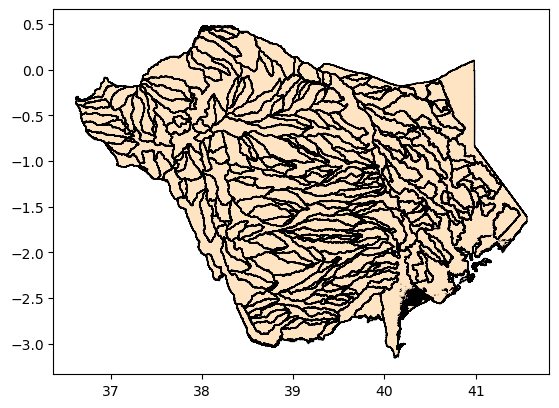

In [5]:

shape_file = os.path.join(shape_path, '*.gpkg')
shape_files = glob.glob(shape_file)
print(shape_file)
gdfs = []

for file in shape_files:
    gdf = gpd.read_file(file)
    gdfs.append(gdf)

merged_gdfs = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
merged_gdfs.plot(color = 'bisque', edgecolor = 'black')

In [6]:
#gdfs

In [7]:
def clip_netCDF_to_geopackage(netCDF_file, geopackage_file):
    # Open the GeoPackage file
    geopackage_gdf = gpd.read_file(geopackage_file)

    # Open the NetCDF file
    with rasterio.open(netCDF_file) as src:
        # Read the NetCDF data
        data = src.read(1)

        # Clip the NetCDF data to the GeoPackage boundaries
        clipped_data, _ = mask(src, geopackage_gdf.geometry, crop=True, nodata=np.nan)

        # Get metadata for the clipped data
        meta = src.meta.copy()

    return clipped_data, meta

# Example usage:
i = 0
start_time = time.time()
clipped_data = []

netCDF_file = data_files[0]  # Assuming data_files contains the list of NetCDF file paths
for geopackage_file in shape_files:  # Assuming shape_files is a list of GeoPackage file paths
    clipped_data_current, meta = clip_netCDF_to_geopackage(netCDF_file, geopackage_file)
    clipped_data.append(clipped_data_current)
    print(geopackage_file)
    i += 1
    if i > 10:
        break;
    print(clipped_data_current.shape)
# clipped_data, meta = clip_netCDF_to_geopackage(chirps_file, shape_files)
end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Shapefiles\Mini_shapes\fid_1021.gpkg
(1826, 5, 9)
C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Shapefiles\Mini_shapes\fid_1027.gpkg
(1826, 10, 5)
C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Shapefiles\Mini_shapes\fid_1036.gpkg
(1826, 1, 2)
C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Shapefiles\Mini_shapes\fid_1048.gpkg
(1826, 5, 17)
C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Shapefiles\Mini_shapes\fid_1076.gpkg
(1826, 6, 13)
C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Shapefiles\Mini_shapes\fid_1086.gpkg
(1826, 4, 6)
C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENV

[[[ 0.]
  [nan]]

 [[ 0.]
  [nan]]

 [[ 0.]
  [nan]]

 ...

 [[ 0.]
  [nan]]

 [[ 0.]
  [nan]]

 [[ 0.]
  [nan]]]
32868


TypeError: Invalid shape (1826, 10, 5) for image data

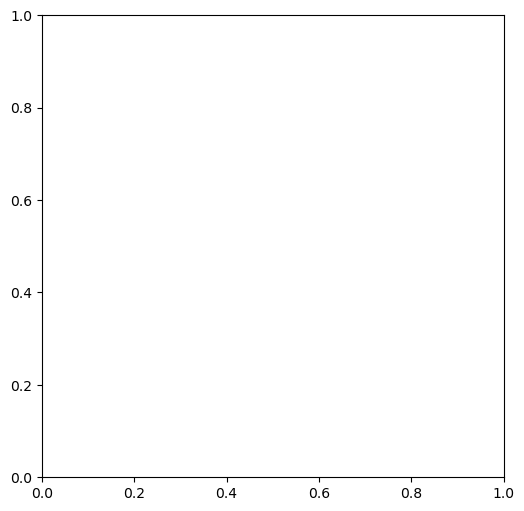

In [8]:
print(clipped_data_current)

for k in range(0, len(clipped_data)):
    clipped_values = np.count_nonzero(~np.isnan(clipped_data[k]))
    print(clipped_values)
    plt.figure(figsize=(8, 6))
    plt.imshow(clipped_data[1])#, extent=[lon_min, lon_max, lat_min, lat_max])
    

plt.colorbar(label='Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clipped NetCDF Data')
plt.grid(True)
plt.show()

In [27]:
# Trying to add the precipitation and location data to the clipped shapefiles

def clip_netCDF_to_geopackage(netCDF_file, geopackage_file):
    # Obtain the name of the shapefile from the GeoPackage file
    shapefile_name = os.path.basename(geopackage_file)

    # Open the GeoPackage file
    geopackage_gdf = gpd.read_file(geopackage_file)

    # Open the NetCDF file
    with rasterio.open(netCDF_file) as src:
        # Read the entire timeseries data
        data = src.read()

        # Clip the NetCDF data to the GeoPackage boundaries
        clipped_data, transform = mask(src, geopackage_gdf.geometry, crop=True, nodata=np.nan)
        
        # Calculate the area of each clipped geometry
        clipped_areas = geopackage_gdf.geometry.area
        
        # Create an xarray Dataset from the clipped data
        clipped_dataset = xr.DataArray(
            clipped_data,
            dims=["time", "y", "x"],
            coords={"time": np.arange(clipped_data.shape[0]), "y": np.arange(clipped_data.shape[1]), "x": np.arange(clipped_data.shape[2])}
        ).to_dataset(name="precipitation")
        
        # Add the clipped areas as a new coordinate variable to the dataset
        clipped_dataset.coords['area_m2'] = (('gdf'), clipped_areas)
        
    return {shapefile_name: clipped_dataset}

# Obtain the names of all the different shapefiles
def get_shapefile_names(folder_path):
    shapefile_names = [file for file in os.listdir(folder_path) if file.endswith('.gpkg')]
    return shapefile_names

# Assuming data_files and shape_files are already defined
dataset_list = []
i = 0

# Remove the break condition to process all shapefiles
netCDF_file = data_files[0]
for geopackage_file in shape_files:
    clipped_dataset = clip_netCDF_to_geopackage(netCDF_file, geopackage_file)
    dataset_list.append(clipped_dataset)
    i  += 1
    if i > 1:
        break
    print('Processing:', geopackage_file)

# Combine all datasets into one (if necessary and feasible)
# combined_dataset = xr.concat(dataset_list, dim='gdf')

C:\Users\Moniek van Zon\AppData\Local\Temp\ipykernel_15000\968294411.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clipped_areas = geopackage_gdf.geometry.area


Processing: C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Shapefiles\Mini_shapes\fid_1021.gpkg


C:\Users\Moniek van Zon\AppData\Local\Temp\ipykernel_15000\968294411.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clipped_areas = geopackage_gdf.geometry.area


TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'dict'>

In [35]:
# shapefile_name = os.path.splitext(os.path.basename(geopackage_file))[0]
clipped_dataset['fid_1027.gpkg']['precipitation']


<xarray.DataArray 'precipitation' (time: 1826, y: 10, x: 5)> Size: 365kB
array([[[      nan,       nan,       nan,       nan,       nan],
        [      nan,       nan,       nan,       nan,       nan],
        [      nan, 0.       ,       nan,       nan,       nan],
        ...,
        [      nan, 0.       , 0.       , 0.       ,       nan],
        [0.       , 0.       , 0.       ,       nan,       nan],
        [0.       , 0.       ,       nan,       nan,       nan]],

       [[      nan,       nan,       nan,       nan,       nan],
        [      nan,       nan,       nan,       nan,       nan],
        [      nan, 0.       ,       nan,       nan,       nan],
        ...,
        [      nan, 0.       , 0.       , 0.       ,       nan],
        [0.       , 0.       , 0.       ,       nan,       nan],
        [0.       , 0.       ,       nan,       nan,       nan]],

       [[      nan,       nan,       nan,       nan,       nan],
        [      nan,       nan,       nan,       nan,       nan],
        [      nan, 0.       ,       nan,       nan,       nan],
        ...,
...
        [      nan, 0.       , 0.       , 0.       ,       nan],
        [0.       , 0.       , 0.       ,       nan,       nan],
        [0.       , 0.       ,       nan,       nan,       nan]],

       [[      nan,       nan,       nan,       nan,       nan],
        [      nan,       nan,       nan,       nan,       nan],
        [      nan, 0.       ,       nan,       nan,       nan],
        ...,
        [      nan, 0.       , 0.       , 0.       ,       nan],
        [0.       , 0.       , 0.       ,       nan,       nan],
        [0.       , 0.       ,       nan,       nan,       nan]],

       [[      nan,       nan,       nan,       nan,       nan],
        [      nan,       nan,       nan,       nan,       nan],
        [      nan, 0.       ,       nan,       nan,       nan],
        ...,
        [      nan, 0.       , 0.       , 0.       ,       nan],
        [0.       , 0.       , 0.       ,       nan,       nan],
        [0.       , 0.       ,       nan,       nan,       nan]]],
      dtype=float32)
Coordinates:
  * time     (time) int32 7kB 0 1 2 3 4 5 6 ... 1820 1821 1822 1823 1824 1825
  * y        (y) int32 40B 0 1 2 3 4 5 6 7 8 9
  * x        (x) int32 20B 0 1 2 3 4

In [23]:
def get_shapefile_names(folder_path):
    shapefile_names = [file for file in os.listdir(folder_path) if file.endswith('.gpkg')]
    return shapefile_names
shapefile_name = get_shapefile_names(shape_path)
shapefile_name

['fid_1021.gpkg',
 'fid_1027.gpkg',
 'fid_1036.gpkg',
 'fid_1048.gpkg',
 'fid_1076.gpkg',
 'fid_1086.gpkg',
 'fid_1091.gpkg',
 'fid_1096.gpkg',
 'fid_1101.gpkg',
 'fid_1107.gpkg',
 'fid_1112.gpkg',
 'fid_1113.gpkg',
 'fid_1114.gpkg',
 'fid_1128.gpkg',
 'fid_1130.gpkg',
 'fid_1131.gpkg',
 'fid_1156.gpkg',
 'fid_1169.gpkg',
 'fid_1173.gpkg',
 'fid_12.gpkg',
 'fid_1207.gpkg',
 'fid_1209.gpkg',
 'fid_1218.gpkg',
 'fid_1220.gpkg',
 'fid_1223.gpkg',
 'fid_1226.gpkg',
 'fid_1236.gpkg',
 'fid_1249.gpkg',
 'fid_1251.gpkg',
 'fid_1259.gpkg',
 'fid_1266.gpkg',
 'fid_1272.gpkg',
 'fid_1286.gpkg',
 'fid_13.gpkg',
 'fid_1344.gpkg',
 'fid_1353.gpkg',
 'fid_1378.gpkg',
 'fid_1424.gpkg',
 'fid_144.gpkg',
 'fid_1520.gpkg',
 'fid_161.gpkg',
 'fid_1665.gpkg',
 'fid_1745.gpkg',
 'fid_1769.gpkg',
 'fid_1792.gpkg',
 'fid_1811.gpkg',
 'fid_1854.gpkg',
 'fid_1878.gpkg',
 'fid_1883.gpkg',
 'fid_1889.gpkg',
 'fid_1894.gpkg',
 'fid_1900.gpkg',
 'fid_1909.gpkg',
 'fid_1913.gpkg',
 'fid_1915.gpkg',
 'fid_1917.gpkg'

In [ ]:
mini_shape_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Shapefiles', 'Mini_shapes')
mini_shape_file = os.path.join(mini_shape_path, '*.gpkg')
mini_shape_files = glob.glob(mini_shape_file)
gdfs_mini = []

print(mini_shape_files)

for file in mini_shape_files:
    gdf_mini = gpd.read_file(file)
    gdfs_mini.append(gdf_mini)

merged_gdfs_mini = gpd.GeoDataFrame(pd.concat(gdfs_mini, ignore_index=True))
merged_gdfs_mini.plot(color = 'bisque', edgecolor = 'black')

In [ ]:
# select one day from the chirps file

mini_1_file = mini_shape_files[100]
mini_1_shape = gpd.read_file(mini_1_file)
mini_1_shape.plot(color= 'bisque')
ds = xr.open_dataset(data_files[0])
ds_day_1 = ds.sel(time = '2018-01-01') # --> Selected day
# print(mini_1_shape)
shape_1 = gpd.read_file(mini_shape_files[0])

clip_1 = shape_1.geometry.values[0]

# print(clip_1)


# with rasterio.open(data_files[0]) as src:
#     # Clip the dataset to the clipping geometry
#     clipped_mini_data, clipped_transform = mask(src, [clip_1], crop=True)

# print(clipped_mini_data)

# geopackage_gdf = gpd.read_file(mini_1_shape)
# clipped_mini, _ = mask(src, geopackage_gdf.geometry.values[0], crop = True, nodata=np.nan)

In [ ]:
ds = xr.open_dataset(data_files[0])  # Assuming data_files contains the list of NetCDF file paths
ds_day_1 = ds.sel(time='2018-01-01')  # Selected day

# Load the GeoPackage shapefile
shape_1 = gpd.read_file(mini_shape_files[0])  # Assuming mini_shape_files contains the path to the shapefile
clip_1 = shape_1.geometry.values[0]  # Assuming the shapefile has only one geometry

# Open the CHIRPS file with rasterio
with rasterio.open(data_files[0]) as src:
    # Clip the CHIRPS data to the clipping geometry
    clipped_mini, _ = mask(src, [clip_1], crop=True, nodata=np.nan)

plt.imshow(clipped_mini, cmap='jet')
plt.colorbar(label='Precipitation (mm)')
plt.title('Clipped CHIRPS Data')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()
